In [10]:
import os
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.integrate import odeint

In [ ]:
CSV_PATH = "./covid-19_smitte_external/03_bekraeftede_tilfaelde_doede_indlagte_pr_dag_pr_koen.csv"

POPULATION = 5_831_000 # Statistics Denmark 2023-01-01
INFECTIOUS_DAYS = 14 # mean days an individual is infectious
INFECTED_LIMIT  = 0 # 2**14 # 2**16 # There need to be at least INFECTED_LIMIT infected for us to care

In [ ]:
print("Reading", CSV_PATH)
raw = pd.read_csv(
    CSV_PATH,
    sep=";",
    encoding="cp1252", # danish chars
)

Reading ./covid-19_smitte_external/03_bekraeftede_tilfaelde_doede_indlagte_pr_dag_pr_koen.csv


### Get elements

In [13]:
cols_lower: List[str] = [c.lower() for c in raw.columns]

def find_col(substrs: List[str]) -> str:
    for col, col_lc in zip(raw.columns, cols_lower):
        if all(s in col_lc for s in substrs):
            return col
    raise KeyError(f"Column containing {substrs} not found")

col_date      = find_col(["dato"])
col_confirmed = find_col(["bekr", "tilf", "alt"]) # new daily cases
col_deaths    = find_col(["døde"]) # new daily deaths

raw[col_date] = pd.to_datetime(raw[col_date], errors="coerce")
raw = raw.rename(columns={
    col_date: "Date",
    col_confirmed: "Confirmed",
    col_deaths: "Deaths",
})

In [14]:
daily = (
    raw.groupby("Date")[["Confirmed", "Deaths"]]
       .sum(min_count=1)
       .sort_index()
)

# Reconstruct S, I, R
cum = daily.cumsum()
cum.columns = ["Confirmed_cum", "Deaths_cum"]

new_cases = daily["Confirmed"].fillna(0)
I = new_cases.rolling(INFECTIOUS_DAYS, min_periods=1).sum()
R = cum["Confirmed_cum"] - I
S = POPULATION - I - R

series = pd.concat({"S": S, "I": I, "R": R}, axis=1).astype(float).clip(lower=0)

# Trim to interval where I >= INFECTED_LIMIT
valid = series["I"] >= INFECTED_LIMIT
first = valid.idxmax()
last = valid[::-1].idxmax()
series = series.loc[first:last]

In [15]:
delta_I = series["I"].diff(); delta_R = series["R"].diff()
valid = (series["I"] > 0) & (series["S"] > 0)

gamma_hat = (delta_R[valid] / series.loc[valid, "I"]).mean()
beta_hat  = (
    (delta_I[valid] + gamma_hat * series.loc[valid, "I"]) /
    (series.loc[valid, "S"] * series.loc[valid, "I"] / POPULATION)
).mean()
R0_hat = beta_hat / gamma_hat
print(f"Estimated beta = {beta_hat}, gamma = {gamma_hat} => R0 = {R0_hat}")

Estimated beta = 0.1321038107327189, gamma = 0.07338095487997708 => R0 = 1.8002465482874916


In [ ]:
Q_hat = np.array([
    [-beta_hat,  beta_hat,   0.0],
    [0.0,       -gamma_hat, gamma_hat],
    [0.0,         0.0,      0.0],
])

p0 = np.array([1, 0, 0])
T  = len(series)
expected_states = np.zeros((T, 3))
scale = 1 # 1/14
for t in range(T):
    expected_states[t] = p0 @ expm(Q_hat * t * scale) * POPULATION

expected = pd.DataFrame(
    expected_states, index=series.index,
    columns=["S_exp", "I_exp", "R_exp"],
)
plot_df = (
    series.rename(columns={"S": "S_obs", "I": "I_obs", "R": "R_obs"})
          .join(expected)
)

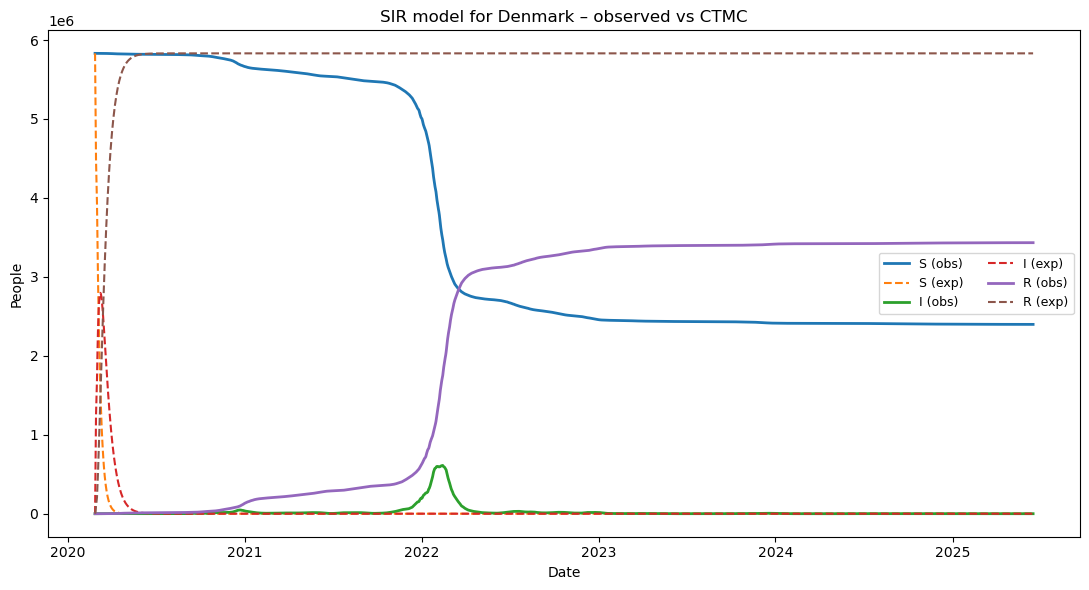

In [17]:
fig, ax = plt.subplots(figsize=(11, 6))
for obs, exp in [("S_obs", "S_exp"), ("I_obs", "I_exp"), ("R_obs", "R_exp")]:
    label = obs.split("_")[0]
    ax.plot(plot_df.index, plot_df[obs], label=f"{label} (obs)", lw=2)
    ax.plot(plot_df.index, plot_df[exp], ls="--", label=f"{label} (exp)")
ax.set(title="SIR model for Denmark – observed vs CTMC",
       xlabel="Date", ylabel="People")
ax.legend(ncol=2, fontsize=9)
fig.tight_layout()
plt.show()

### Simulate (odeint)
Using existing tool for "solving" sets of ordinary coupled differential equations - scipys odeint.

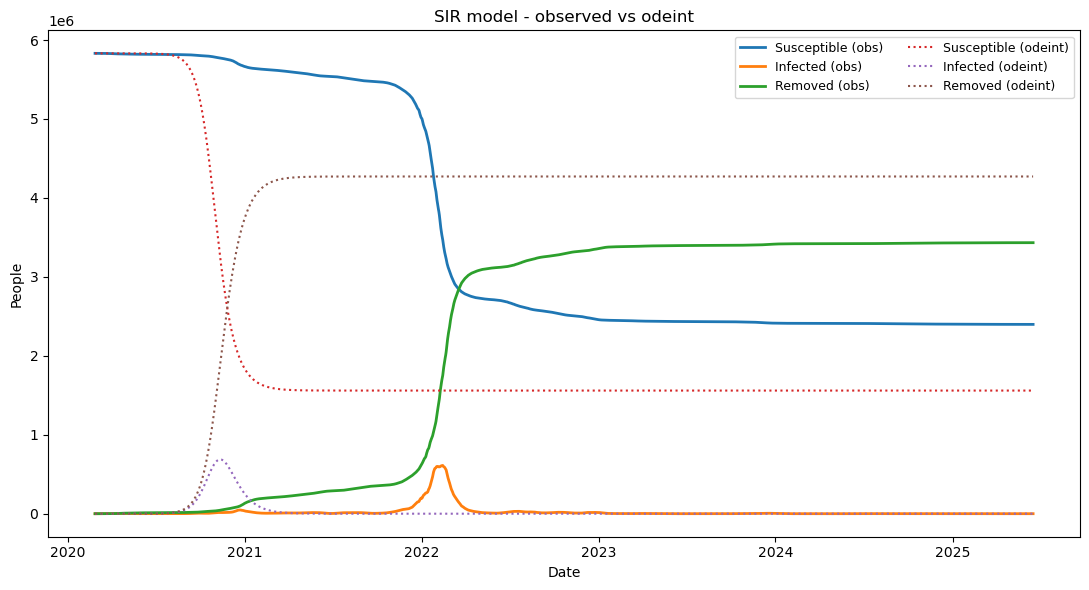

In [18]:
def sir_deriv(y, t, beta, gamma, N):
    S, I, R = y
    return (
        -beta * S * I / N,
         beta * S * I / N - gamma * I,
         gamma * I,
    )

y0 = series.iloc[0].values
t  = np.arange(T)
S_sim, I_sim, R_sim = odeint(
    sir_deriv, y0, t,
    args=(beta_hat, gamma_hat, POPULATION)
).T

plt.figure(figsize=(11, 6))
# Observed
plt.plot(series.index, series["S"], lw=2, label="Susceptible (obs)")
plt.plot(series.index, series["I"], lw=2, label="Infected (obs)")
plt.plot(series.index, series["R"], lw=2, label="Removed (obs)")
# Simulated
plt.plot(series.index, S_sim, ":", label="Susceptible (odeint)")
plt.plot(series.index, I_sim, ":", label="Infected (odeint)")
plt.plot(series.index, R_sim, ":", label="Removed (odeint)")

plt.title("SIR model - observed vs odeint")
plt.xlabel("Date"); plt.ylabel("People")
plt.legend(fontsize=9, ncol=2)
plt.tight_layout(); plt.show()
